In [1]:
# Manejo de datos
##Leer CSV
import pandas as pd
import numpy as np

# Para procesar los datos 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
#nltk.download('stopwords')
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')



# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# DL
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

#Metricas de precision
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
##Archivo de lectura
df = pd.read_csv('Dataset/spam_ham_dataset.csv')
# Quitamos columnas innecesarias
df.drop('Unnamed: 0', axis=1, inplace = True)
# Cambiamos el nombre de las columnas 
df.columns = ['etiqueta', 'texto', 'clase']

In [3]:
##mostramos cabecera con los datos
df.head(10)


,etiqueta,texto,clase
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,ham,Subject: ehronline web address change\r\nthis ...,0
6,ham,Subject: spring savings certificate - take 30 ...,0
7,spam,Subject: looking for medication ? we ` re the ...,1
8,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [4]:
print(f'El dataset tiene un total de {df.shape[0]} E-Mails, pueden categorizarse en ham y spam')

El dataset tiene un total de 5171 E-Mails, pueden categorizarse en ham y spam


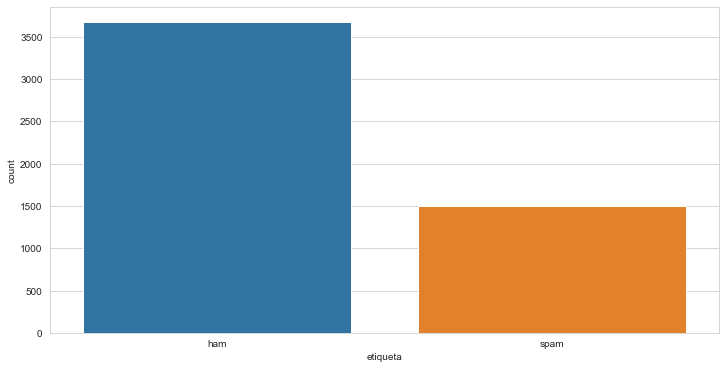

In [5]:
plt.figure(figsize = (12, 6))
sns.countplot(data = df, x = 'etiqueta');

In [6]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

In [7]:

#limpiamos los datos

stop_words = set(stopwords.words('english')) 

df['texto'] = df['texto'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

In [8]:
df['texto'] = df['texto'].apply(lambda string: clean_str(string))
#Mostramos los datos en limpio
df.head()


,etiqueta,texto,clase
0,ham,subject enron methanol meter follow note gave ...,0
1,ham,subject hpl nom january see attached file hpln...,0
2,ham,subject neon retreat ho ho ho around wonderful...,0
3,spam,subject photoshop windows office cheap main tr...,1
4,ham,subject indian springs deal book teco pvr reve...,0


In [9]:
# Convertir una colección de documentos de texto en una matriz de recuentos de tokens
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.texto)

y = df.etiqueta



In [10]:
#Dividir arreglos o matrices en subconjuntos de prueba y tren aleatorio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle = True)

print(f"Tren de entrenamiento: {X_train.shape}\nTren de prueba: {X_test.shape}")


Tren de entrenamiento: (4136, 45595)
Tren de prueba: (1035, 45595)


In [11]:
print(f"NÚMERO DE OBSERVACIONES: {X.shape[0]}\nTOKENS: {X.shape[1]}")


NÚMERO DE OBSERVACIONES: 5171
TOKENS: 45595


In [12]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "ComplementNB": {"model":ComplementNB(), "perf":0},  
    "BernoulliNB": {"model":BernoulliNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} Entrenado en {duration} sec")

Random Forest        Entrenado en 8.13 sec
Gradient Boosting    Entrenado en 34.35 sec
XGBoost              Entrenado en 7.0 sec
MultinomialNB        Entrenado en 0.03 sec
ComplementNB         Entrenado en 0.02 sec
BernoulliNB          Entrenado en 0.02 sec
Logistic Regr.       Entrenado en 0.94 sec
KNN                  Entrenado en 0.01 sec
Decision Tree        Entrenado en 1.48 sec
SVM (Linear)         Entrenado en 0.27 sec
SVM (RBF)            Entrenado en 4.62 sec


In [13]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])
    df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Exactitud', 'Tiempo de entrenamiento (sec)']
df_acc.sort_values(by = 'Exactitud', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Exactitud,Tiempo de entrenamiento (sec)
0,Random Forest,0.978744,8.13
1,ComplementNB,0.978744,0.02
2,MultinomialNB,0.977778,0.03
3,Logistic Regr.,0.976812,0.94
4,XGBoost,0.970048,7.00
5,SVM (RBF),0.969082,4.62
6,SVM (Linear),0.967150,0.27
7,Gradient Boosting,0.961353,34.35
8,Decision Tree,0.937198,1.48
9,BernoulliNB,0.845411,0.02


In [14]:
# Busca el mejor hyperparameter con GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

print("Tuned Hpyerparameters :",grid.best_params_)
print("Exactitud :",grid.best_score_)

# Crea un DataFrame con el mejor Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

Tuned Hpyerparameters : {'alpha': 0.2, 'fit_prior': False}
Exactitud : 0.9792074841257323


,params,mean_test_score
1,"{'alpha': 0.2, 'fit_prior': False}",0.979207
3,"{'alpha': 1, 'fit_prior': False}",0.977999
5,"{'alpha': 2, 'fit_prior': False}",0.977997
2,"{'alpha': 1, 'fit_prior': True}",0.977273
0,"{'alpha': 0.2, 'fit_prior': True}",0.976789
4,"{'alpha': 2, 'fit_prior': True}",0.973887
7,"{'alpha': 5, 'fit_prior': False}",0.964458
6,"{'alpha': 5, 'fit_prior': True}",0.956963
9,"{'alpha': 10, 'fit_prior': False}",0.945599
8,"{'alpha': 10, 'fit_prior': True}",0.937619


In [15]:
# Crea un modelo con hyperparameters
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)




model.fit(X_train,y_train)
y_pred = model.predict(X_test)



In [16]:
from sklearn.metrics import classification_report, accuracy_score
print(f'## Exactitud: {round(accuracy_score(y_test,y_pred))*100}%\n')

## Exactitud: 100%



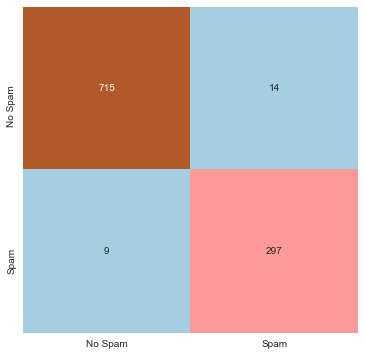

In [17]:
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam']);

In [18]:
def display_result(df, number=2):
    for i in range(number):
        msg = df['texto'].iloc[i]
        label = df["etiqueta"].iloc[i]
        msg_vec = cv.transform([msg])
        pred_label = model.predict(msg_vec)
        print(f"**Real: {label}, Prediccion: {pred_label[0]}**")
        print(f"**E-Mail:** {msg}")
        print("_______________________________________________________________")
    



In [19]:
df_spam = df[df['etiqueta'] == 'spam']
df_ham = df[df['etiqueta'] == 'ham']
display_result(df_spam)
display_result(df_ham)

**Real: spam, Prediccion: spam**
**E-Mail:** subject photoshop windows office cheap main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin
_______________________________________________________________
**Real: spam, Prediccion: spam**
**E-Mail:** subject looking medication best source difficult make material condition better best law easy enough ruin bad laws excuse found best simpliest site medication net perscription easy delivery private secure easy better see rightly pound week squint million got anything ever want erection treatment pills anti depressant pills weight loss http splicings bombahakcx com knowledge human power synonymous high quality stuff low rates moneyback guarantee go

In [20]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Numero de características

model_red = Sequential()
model_red.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model_red.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model_red.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_red.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                455960    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 455,971
Trainable params: 455,971
Non-trainable params: 0
_________________________________________________________________


In [22]:
df_spam.to_csv('Dataset/leidos_spam.csv', sep='\t')